# Algoritmos Genéticos

Algoritmos genéticos (AGs) são uma classe de algoritmos de otimização inspirada no processo evolutivo biológico, que fazem parte do que se chama de computação evolutiva. AGs são inspirados em modelos biológicos, e se fundamentam na Genética de Mendel (1965) e também na Teoria da Evolução de Darwin (1959), usando uma medida para avaliar a capacidade que os indivíduos de uma população têm para sobriver e se reproduzir.

Dessa forma, espera-se que as características dos indivíduos ''mais aptos'', que se reproduzem, em uma geração sejam  transferidas para a próxima geração. Em linhas gerais, esses algoritmos criam diversas soluções aleatoriamente para um problema, das quais serão selecionadas as que apresentarem melhor performance (ou fitness, em inglês). Mais soluções são geradas a partir das selecionadas, e esse processo é repetido diversas vezes até que se encontre uma solução satisfatória. Esse processo é análogo à seleção natural, pensando-se em uma população de soluções (cada solução seria um indivíduo).

<img src='https://miro.medium.com/max/1039/1*VCu7NNV3XbpLfJbcTng1Eg.png' width='500px'/>

Como o algoritmo é baseado num conceito biológico, em geral, utilizamos alguns jargões da biologia quando falamos de aspectos do AG. Na tabela a seguir, você pode verificar as analogias entre alguns termos utilizados na biologia e em AGs:

<img src='https://miro.medium.com/max/848/1*dnQ2bIeT0zHCNtChz5i3Yg.png' width='500px'/>

## Overview

A ideia do algoritmo genético é selecionar as melhores soluções de um problema e fazer com que elas se perpetuem. Podemos definir como um pseudocódigo do AG o seguinte:


    ENTRADA: População Inicial (aleatória)
             Função de Fitness
             Critério de Parada
             
    REPITA (até que o critério de parada seja atendido):
    
        PASSO 1: Aplicar a função de fitness a cada indivíduo
        PASSO 2: Selecionar os x melhores indivíduos
        PASSO 3: Reprodução
                - Aplicar o crossover a um par (com prob = p)
                - Aplicar mutação (com prob = p’)
        PASSO 4: Formar uma nova população com os filhos gerados
  
  
    SAÍDA: Melhor indivíduo presente na geração final    


## O que iremos fazer?

Neste *notebook*, iremos utilizar AGs para criar um modelo capaz de jogar o [chrome-trex-rush](https://github.com/fernandokm/chrome-trex-rush) -- uma versão, em Python, do *game* T-Rex embutido no Google Chrome. 

Assim, o nosso modelo que controlará o dinossauro poderá assumir três possíveis ações:
    - Pular
    - Agachar
    - Não fazer nada


Nossa função de decisão não nos retornará um número, mas sim um vetor com três números (um para cada ação) e nós vamos escolher a ação cuja função nos dê o maior output dentre os três.

Para instalarmos esse pacote, basta executar a célula abaixo:

In [2]:
! pip install --user git+https://github.com/fernandokm/chrome-trex-rush@master

  Cloning https://github.com/fernandokm/chrome-trex-rush (to revision master) to /tmp/pip-req-build-s7dckj__
  Running command git clone -q https://github.com/fernandokm/chrome-trex-rush /tmp/pip-req-build-s7dckj__
^C
ERROR: Operation cancelled by user


## Go!

In [10]:
import seaborn as sns

%matplotlib inline

In [3]:
import numpy as np
import random
# from chrome_trex import DinoGame

CHANCE_MUT = .20     # Chance de mutação de um peso qualquer
CHANCE_CO = .25      # Chance de crossing over de um peso qualquer
NUM_INDIVIDUOS = 15  # Tamanho da população
NUM_MELHORES = 3     # Número de indivíduos que são mantidos de uma geração para a próxima

In [6]:
def populacao_aleatoria(n):
    """
    Argumentos da Função:
        n: Número de indivíduos
    Saída:
        Uma população aleatória. População é uma lista de indivíduos,
        e cada indivíduo é uma matriz 3x10 de pesos (números).
        Os indivíduos podem tomar 3 ações (0, 1, 2) e cada linha da matriz
        contém os pesos associados a uma das ações.
    """
    return [np.random.uniform(-10, 10, size=(3, 10)) for i in range(n)]

In [ ]:
! pip install matplotlib==3.0.3

     |██████████████████▋             | 7.6MB 11kB/s eta 0:08:10

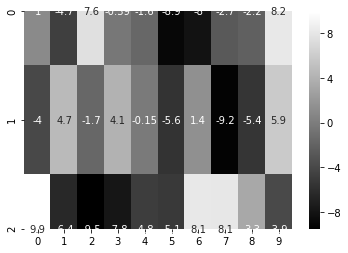

In [13]:
sns.heatmap(populacao_aleatoria(2)[0],annot=True, cmap='gray')

--- 
<span style='font-family: verdana; color: gray'>Notebook baseado no artigo <a href='https://medium.com/turing-talks/turing-talks-8-algoritmos-gen%C3%A9ticos-a791c25bd7ba'>Algoritmos Genéticos: Um primeiro modelo de Machine Learning baseado na seleção natural</a>, do blog <b>TuringTalks</b>.</span>